In [ ]:
#Code to compute the velocity impulse and specific internal energy change during impulsive encounter
#with a spherical perturber along straight orbit

#Computes and plots both non-perturbative and tidal limit local specific \Delta E_int vs y
#for different values of impact parameter and encounter velocity

#-------Created by Uddipan Banik-------

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import random
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.pylab import *
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.ticker as ticker
from matplotlib.patches import BoxStyle
from scipy import integrate
from scipy import optimize
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline,interp1d
from scipy.special import erf as errorfunc
from scipy.special import gamma, factorial
from scipy.signal import argrelextrema 
from matplotlib import cm
from numpy import linalg
import time
import os
import h5py
import string
from straight_functions_spherical_perturber import *

#-----------------------------------------------------------------



In [3]:
#-------Input parameters-------

mass_ratio=1                 #Subject mass Ms/Perturber mass Mp
rp=1e0                       #Perturber scale radius rp in units of rs: 1e-2 -> 1e2
Rc=1                         #Truncation radius in units of rs
rmax=100                      #Maximum radius for integration over subject profile; should be at least 2 times bmax
epsinit=1e-7

perturber_flag=2             #perturber_flag: 1: Point mass, 2: Plummer sphere, 3: Hernquist sphere, 4: NFW, 5: Isochrone
subject_flag=1               #subject_flag: 1: Plummer sphere, 2: Hernquist sphere, 3: NFW
if (subject_flag==3):
    c1=Rc                    #NFW concentration
    c2=rmax
else:
    c1=np.nan
    c2=np.nan

bmin=1e-1                    #Minimum impact parameter
bmax=1e1                     #Maximum impact parameter
Nb=3                         #No of points for impact parameter
impact=np.logspace(np.log10(bmin),np.log10(bmax),num=Nb) #Impact parameter

vpmin=1e-1                   #Minimum encounter velocity
vpmax=1e1                    #Maximum encounter velocity
Nvp=3                        #No of points for encounter velocity
vp=np.logspace(np.log10(vpmin),np.log10(vpmax),num=Nvp)

adcorr_flag=0                #Adiabatic correction- 1: on, 0: off

#-----------------------------------------------------------------


In [4]:
#-------Local velocity and specific internal energy change of subject star-------



#Subject star coordinates

eps=1e-3
xsubmin=eps
xsubmax=rmax
Nxsub=50
ysubmin=eps
ysubmax=rmax
Nysub=500
zsubmin=eps
zsubmax=rmax
Nzsub=50

xsub1=np.logspace(np.log10(xsubmin),np.log10(xsubmax),num=(int)(Nxsub/2))
xsub1flip=-np.flip(xsub1)
xsub=np.array(xsub1flip.tolist()+xsub1.tolist())

ysub1=np.logspace(np.log10(ysubmin),np.log10(ysubmax),num=(int)(Nysub/2))
ysub1flip=-np.flip(ysub1)
ysub=np.array(ysub1flip.tolist()+ysub1.tolist())

zsub1=np.logspace(np.log10(zsubmin),np.log10(zsubmax),num=(int)(Nzsub/2))
zsub1flip=-np.flip(zsub1)
zsub=np.array(zsub1flip.tolist()+zsub1.tolist())


#For adiabatic correction

if (subject_flag==3):
    xM1=Menc(Rc,subject_flag)/(np.log(1+c1)-c1/(1+c1))
    xM2=Menc(rmax,subject_flag)/(np.log(1+c2)-c2/(1+c2))
else:
    xM1=Menc(Rc,subject_flag)
    xM2=Menc(rmax,subject_flag)
Rhalf1=half_mass_radius(xM1,c1,subject_flag)         #Half mass radius (Truncation radius 1=Rc)
Rhalf2=half_mass_radius(xM2,c2,subject_flag)         #Half mass radius (Truncation radius 2=rmax)

Mtrunc1=Menc(Rc,subject_flag)                        #Mass (Truncation radius 1=Rc)
Mtrunc2=Menc(rmax,subject_flag)                      #Mass (Truncation radius 2=rmax)


#General impulse
delvx=np.zeros((Nb,Nvp,Nxsub,Nysub,Nzsub))           #Velocity change along x in units of (2*G*Mp)/(rs*sigma), sigma=sqrt((G*Ms)/rs)
delvy=np.zeros((Nb,Nvp,Nxsub,Nysub,Nzsub))           #Velocity change along y in units of (2*G*Mp)/(rs*sigma)
delvz=np.zeros((Nb,Nvp,Nxsub,Nysub,Nzsub))           #Velocity change along z in units of (2*G*Mp)/(rs*sigma)
delvcm=np.zeros((Nb,Nvp))                            #COM velocity in units of (2*G*Mp)/(rs*sigma)
delEint=np.zeros((Nb,Nvp,Nxsub,Nysub,Nzsub))         #Specific internal energy change in units of ((2*G*Mp)/(rs*sigma))^2

#Distant tide approx. (Gnedin et al. 1999) impulse
delvxtidal=np.zeros((Nb,Nvp,Nxsub,Nysub,Nzsub))      #Velocity change along x in units of (2*G*Mp)/(rs*sigma), sigma=sqrt((G*Ms)/rs)
delvytidal=np.zeros((Nb,Nvp,Nxsub,Nysub,Nzsub))      #Velocity change along y in units of (2*G*Mp)/(rs*sigma)
delvztidal=np.zeros((Nb,Nvp,Nxsub,Nysub,Nzsub))      #Velocity change along z in units of (2*G*Mp)/(rs*sigma)
delEinttidal=np.zeros((Nb,Nvp,Nxsub,Nysub,Nzsub))    #Specific internal energy change in units of ((2*G*Mp)/(rs*sigma))^2

I0_per=np.zeros(Nb)
I1_per=np.zeros(Nb)
J0_per=np.zeros(Nb)
J1_per=np.zeros(Nb)
    
start=time.time()
for i in range(Nb):
    
    I0_per[i]=I0(impact[i],rp,perturber_flag)
    I1_per[i]=I1(impact[i],rp,perturber_flag)
    J0_per[i]=J0(impact[i],rp,perturber_flag)
    J1_per[i]=J1(impact[i],rp,perturber_flag)
    
    for v in range(Nvp):
        delvcm[i][v]=vCM(impact[i],rmax,rp,perturber_flag,subject_flag)/vp[v]
        for j in range(Nxsub):
            for k in range(Nysub):
                for l in range(Nzsub):
                    rsub=np.sqrt(xsub[j]**2+ysub[k]**2+zsub[l]**2)
                    
                    delvx[i][v][j][k][l]=vx(xsub[j],ysub[k],zsub[l],impact[i],rp,perturber_flag)/vp[v]
                    delvy[i][v][j][k][l]=vy(xsub[j],ysub[k],zsub[l],impact[i],rp,perturber_flag)/vp[v]
                    delvz[i][v][j][k][l]=vz(xsub[j],ysub[k],zsub[l],impact[i],rp,perturber_flag)/vp[v]
                    
                    if (adcorr_flag==1):
                        adcorr=adiabatic_correction(rsub,impact[i],vp[v],Rhalf2,Mtrunc2,adcorr_flag,subject_flag)
                    else:
                        adcorr=1
                        
                    delEint[i][v][j][k][l]=0.5*adcorr*(delvx[i][v][j][k][l]**2+(delvy[i][v][j][k][l]-delvcm[i][v])**2+delvz[i][v][j][k][l]**2)
                    
                    delvxtidal[i][v][j][k][l]=-(1/(impact[i]**2*vp[v]))*I0_per[i]*xsub[j]
                    delvytidal[i][v][j][k][l]=(1/(impact[i]**2*vp[v]))*(3*J0_per[i]-J1_per[i]-I0_per[i])*ysub[k]
                    delvztidal[i][v][j][k][l]=(1/(impact[i]**2*vp[v]))*(2*I0_per[i]-I1_per[i]-3*J0_per[i]+J1_per[i])*zsub[l]
                    delEinttidal[i][v][j][k][l]=0.5*adcorr*(delvxtidal[i][v][j][k][l]**2+delvytidal[i][v][j][k][l]**2+delvztidal[i][v][j][k][l]**2)
    
    end=time.time()
    print ("%d\tTime taken: %f s\n" %(i,abs(end-start)))


0	Time taken: 170.334160 s



/home/uddipan/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)


1	Time taken: 284.750489 s

2	Time taken: 395.248606 s



In [5]:
#-------Writing data in a file-------

hf = h5py.File('impulsive_straight_orbit_impulse_perturber%d_subject%d_massratio_%.3f_rp%.3f.h5' %(perturber_flag,subject_flag,mass_ratio,rp), 'w')
hf.create_dataset('impact', data=impact)
hf.create_dataset('vp', data=vp)
hf.create_dataset('xsub', data=xsub)
hf.create_dataset('ysub', data=ysub)
hf.create_dataset('zsub', data=zsub)
hf.create_dataset('delvx', data=delvx)
hf.create_dataset('delvy', data=delvy)
hf.create_dataset('delvz', data=delvz)
hf.create_dataset('delvcm', data=delvcm)
hf.create_dataset('delEint', data=delEint)
hf.create_dataset('delvxtidal', data=delvx)
hf.create_dataset('delvytidal', data=delvy)
hf.create_dataset('delvztidal', data=delvz)
hf.create_dataset('delEinttidal', data=delEint)
hf.close()

/home/uddipan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/home/uddipan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


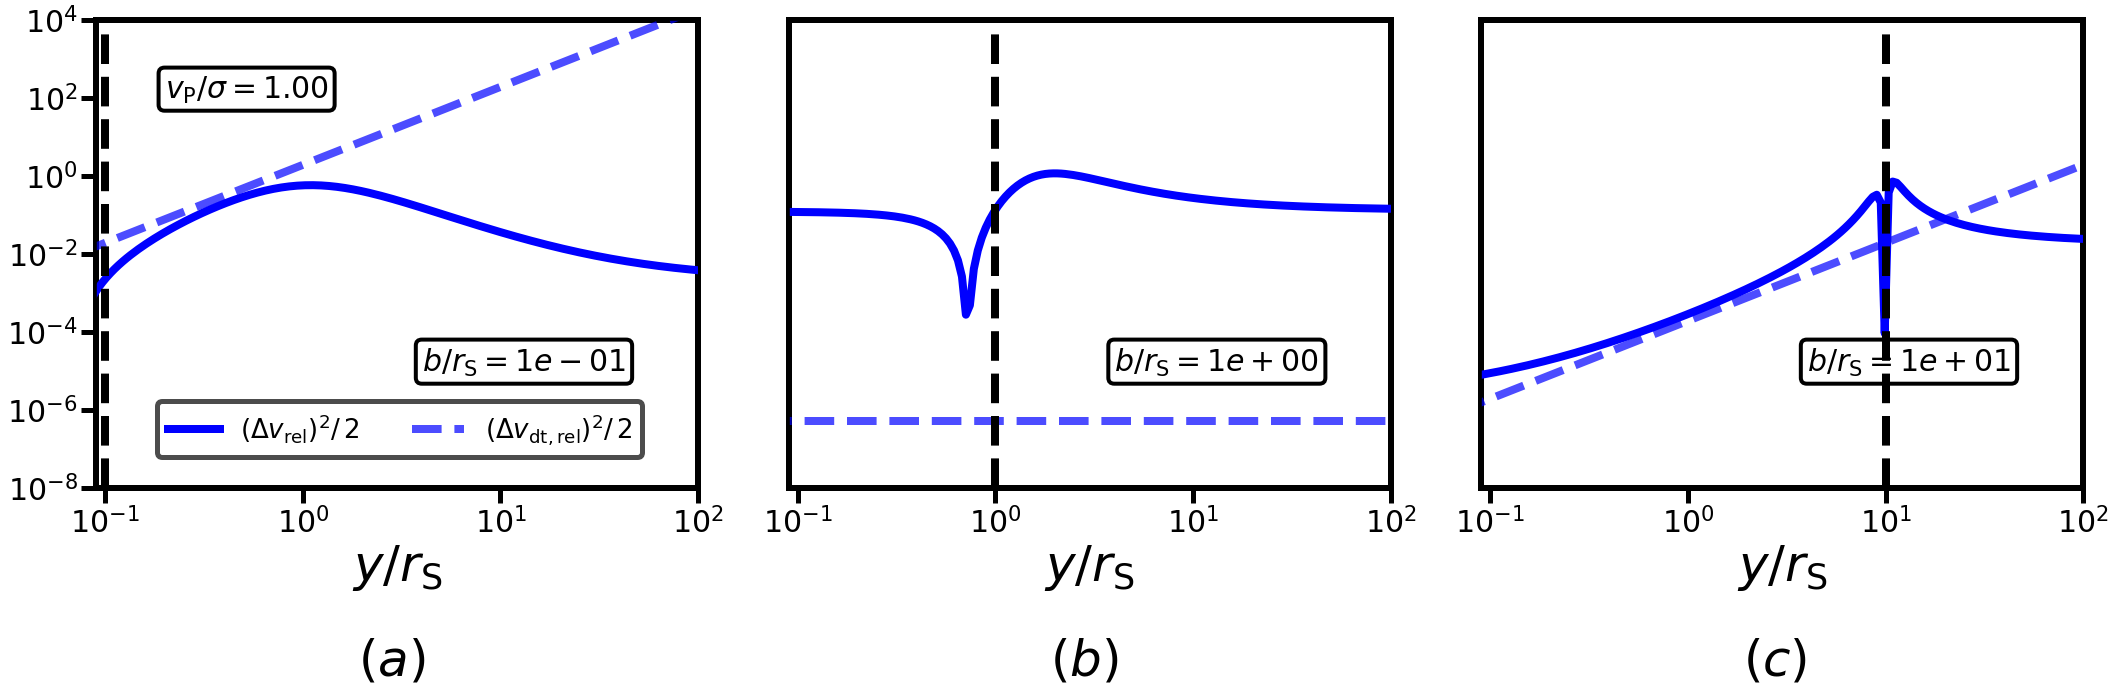

In [17]:
#-------Plot-------

fig,ax=plt.subplots(1,3,figsize=(30,10))
plt.subplots_adjust(left=0.05,right=0.97,bottom=0.3,top=0.95,wspace=0.15)

#ax[0].plot(ysub,(4/mass_ratio**2)*delEint[0,0,(int)(Nxsub/2),:,(int)(Nzsub/2)],color='r',lw=8,label='${\left(\Delta v_{\mathrm{rel}}\\right)}^2/\,2$')
#ax[0].plot(ysub,(4/mass_ratio**2)*delEinttidal[0,0,(int)(Nxsub/2),:,(int)(Nzsub/2)],color='r',alpha=0.7,lw=8,ls='--',label='${\left(\Delta v_{\mathrm{dt,rel}}\\right)}^2/\,2$')
ax[0].plot(ysub,(4/mass_ratio**2)*delEint[0,Nvp-2,(int)(Nxsub/2),:,(int)(Nzsub/2)],color='b',lw=8,label='${\left(\Delta v_{\mathrm{rel}}\\right)}^2/\,2$')
ax[0].plot(ysub,(4/mass_ratio**2)*delEinttidal[0,Nvp-2,(int)(Nxsub/2),:,(int)(Nzsub/2)],color='b',alpha=0.7,lw=8,ls='--',label='${\left(\Delta v_{\mathrm{dt,rel}}\\right)}^2/\,2$')

ax[0].set_xscale('symlog',linthreshx=eps)
ax[0].set_yscale('log')
ax[0].axvline(x=impact[0],color='k',lw=8,ls='--')
ax[0].set_xlabel('$y/r_{\mathrm{S}}$',fontsize=50)
ax[0].tick_params(which='major', width=5, length=15, color='k')
ax[0].tick_params(which='minor', width=4, length=10, color='k')
ax[0].set_xticks(np.logspace(-1,np.log10(rmax),num=4))
ax[0].tick_params(labelsize=30)
ax[0].set_xlim([9e-2,rmax])
ax[0].set_ylim([1e-8,1e4])
ax[0].patch.set_edgecolor('k')
ax[0].patch.set_linewidth('6')
leg=ax[0].legend(ncol=2,bbox_to_anchor=[0.08, 0.125], loc='center left',handlelength=2,facecolor='white',framealpha=0.7,fontsize=26)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth('5.0')
ax[0].text(4, 1e-5, '$b/r_{\mathrm{S}}=%.0e$' %(impact[0]), bbox=dict(boxstyle='round', facecolor='none', edgecolor='black',linewidth=4, pad=0.2, alpha=1), fontsize=30)
ax[0].text(0.2, 1e2, '$v_{\mathrm{P}}/\sigma=%.2f$' %(vp[Nvp-2]), bbox=dict(boxstyle='round', facecolor='none', edgecolor='black',linewidth=4, pad=0.2, alpha=1), fontsize=30)
ax[0].text(0.435, -0.4, '$(%s)$' %(string.ascii_lowercase[0]), transform=ax[0].transAxes, size=50)



#ax[1].plot(ysub,(4/mass_ratio**2)*delEint[1,0,(int)(Nxsub/2),:,(int)(Nzsub/2)],color='r',lw=8)
#ax[1].plot(ysub,(4/mass_ratio**2)*delEinttidal[1,0,(int)(Nxsub/2),:,(int)(Nzsub/2)],color='r',alpha=0.7,lw=8,ls='--')
ax[1].plot(ysub,(4/mass_ratio**2)*delEint[1,Nvp-2,(int)(Nxsub/2),:,(int)(Nzsub/2)],color='b',lw=8)
ax[1].plot(ysub,(4/mass_ratio**2)*delEinttidal[1,Nvp-2,(int)(Nxsub/2),:,(int)(Nzsub/2)],color='b',alpha=0.7,lw=8,ls='--')

ax[1].set_yscale('log')
ax[1].set_xscale('symlog',linthreshx=eps)
ax[1].axvline(x=impact[1],color='k',lw=8,ls='--')
ax[1].set_xlabel('$y/r_{\mathrm{S}}$',fontsize=50)
ax[1].tick_params(which='major', width=5, length=15, color='k')
ax[1].tick_params(which='minor', width=4, length=10, color='k')
ax[0].set_xticks(np.logspace(-1,np.log10(rmax),num=4))
ax[1].set_yticks([],[])
ax[1].tick_params(labelsize=30)
ax[1].set_xlim([9e-2,rmax])
ax[1].set_ylim([1e-8,1e4])
ax[1].patch.set_edgecolor('k')
ax[1].patch.set_linewidth('6')
ax[1].text(4, 1e-5, '$b/r_{\mathrm{S}}=%.0e$' %(impact[1]), bbox=dict(boxstyle='round', facecolor='none', edgecolor='black', linewidth=4, pad=0.2, alpha=1), fontsize=30)
ax[1].text(0.435, -0.4, '$(%s)$' %(string.ascii_lowercase[1]), transform=ax[1].transAxes, size=50)



#ax[2].plot(ysub,(4/mass_ratio**2)*delEint[2,0,(int)(Nxsub/2),:,(int)(Nzsub/2)],color='r',lw=8)
#ax[2].plot(ysub,(4/mass_ratio**2)*delEinttidal[2,0,(int)(Nxsub/2),:,(int)(Nzsub/2)],color='r',alpha=0.7,lw=8,ls='--')
ax[2].plot(ysub,(4/mass_ratio**2)*delEint[2,Nvp-2,(int)(Nxsub/2),:,(int)(Nzsub/2)],color='b',lw=8)
ax[2].plot(ysub,(4/mass_ratio**2)*delEinttidal[2,Nvp-2,(int)(Nxsub/2),:,(int)(Nzsub/2)],color='b',alpha=0.7,lw=8,ls='--')

ax[2].set_yscale('log')
ax[2].set_xscale('symlog',linthreshx=eps)
ax[2].axvline(x=impact[2],color='k',lw=8,ls='--')
ax[2].set_xlabel('$y/r_{\mathrm{S}}$',fontsize=50)
ax[2].tick_params(which='major', width=5, length=15, color='k')
ax[2].tick_params(which='minor', width=4, length=10, color='k')
ax[0].set_xticks(np.logspace(-1,np.log10(rmax),num=4))
ax[2].set_yticks([],[])
ax[2].tick_params(labelsize=30)
ax[2].set_xlim([9e-2,rmax])
ax[2].set_ylim([1e-8,1e4])
ax[2].patch.set_edgecolor('k')
ax[2].patch.set_linewidth('6')
ax[2].text(4, 1e-5, '$b/r_{\mathrm{S}}=%.0e$' %(impact[2]), bbox=dict(boxstyle='round', facecolor='none', edgecolor='black', linewidth=4, pad=0.2, alpha=1), fontsize=30)
ax[2].text(0.435, -0.4, '$(%s)$' %(string.ascii_lowercase[2]), transform=ax[2].transAxes, size=50)

plt.savefig('impulse_perturber%d_subject%d_massratio%.3f_rp%.3f.jpeg' %(perturber_flag,subject_flag,mass_ratio,rp))

plt.show()